# 'Problem' Project on Diabetes Classification

+ Pregnancies: Number of times pregnant
+ Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
+ BloodPressure: Diastolic blood pressure (mm Hg)
+ SkinThickness: Triceps skin fold thickness (mm)
+ Insulin: 2-Hour serum insulin (mu U/ml)
+ BMI: Body mass index (weight in kg/(height in m)^2)
+ DiabetesPedigreeFunction: Diabetes pedigree function
+ Age: Age (years)
+ Outcome: Class variable (0 or 1)

## Contents

# TODO:
+ gridsearch to optimize algorithms knn, svc, dtc with crossvalidation
+ clean analysis
+ make nice tables for each observation

# 1. Initialization

In [1]:
# import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

from statistics import mean, stdev

# for evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# tuning
from sklearn.model_selection import GridSearchCV


# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std

In [2]:
# auxiliary functions



# 2. Data Preprocessing

## 2.1 Exploratory Data Analysis

In [3]:
diabetes_data = pd.read_csv("../input/diabetes-data-set/diabetes.csv")
column_names = diabetes_data.columns.to_numpy()
attributes = column_names[0:8]

In [4]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


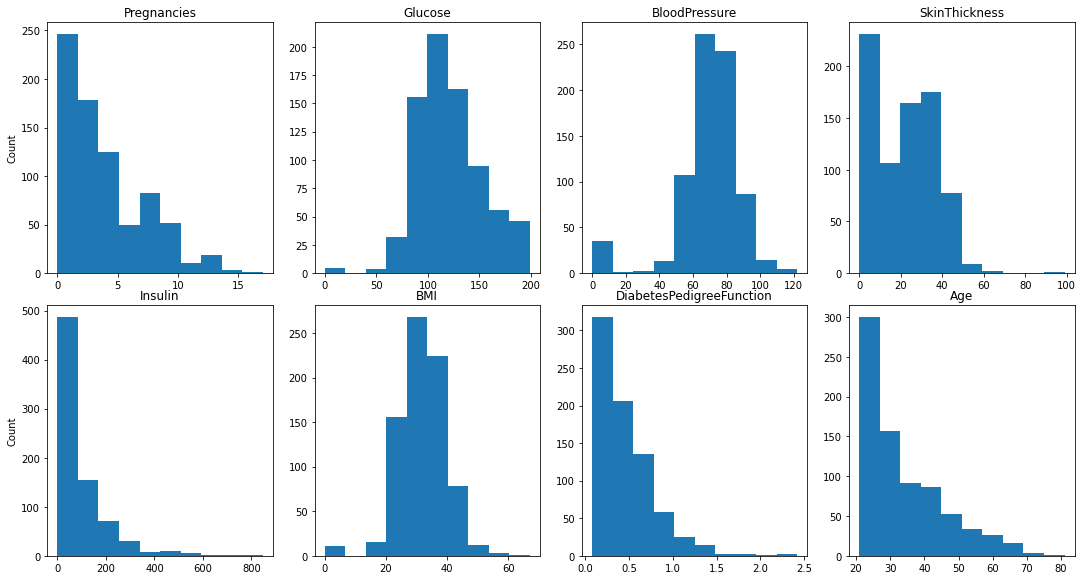

In [7]:
X = pd.DataFrame(diabetes_data).to_numpy()[:, 0:8]

fig, ax = plt.subplots(2,4,figsize=(15,8))
fig.tight_layout()

col = 0
for i in range(2):
    ax[i, 0].set_ylabel('Count')
    for j in range(4):
        ax[i, j].hist(X[:, col])  
        ax[i, j].set_title(column_names[col])   
        col += 1
plt.show()

+ We can see that the minimum value of some columns is 0, for pregnancies this seems indeed possible but for the other columns this is not logical.
+ We can see that the data does not contain any null values and the datatypes are all numerical

## 2.2 Missing Values Handling

We will create a new dataset and replace the new values of the columns with the NaN <br>
We want to know how many zero values<br>
So we have to replace the null values with the mean of the column, such that the data is not completely wasted.<br>

In [8]:
diabetes_data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
# replace 0 value for columns where zero value does not make sense with NaN
diabetes_data_new = diabetes_data
diabetes_data_new[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] = diabetes_data_new[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]].replace(0, np.NaN)

In [10]:
diabetes_data_new.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [11]:
# TODO: create nice table
percentages = []
for i in diabetes_data_new.isnull().sum().values:
    percentages.append((i / 768) * 100)
for i in range(len(percentages)):
    print(column_names[i], ": \t", round(percentages[i], 2), " %")

Pregnancies : 	 0.0  %
Glucose : 	 0.65  %
BloodPressure : 	 4.56  %
SkinThickness : 	 29.56  %
Insulin : 	 48.7  %
BMI : 	 1.43  %
DiabetesPedigreeFunction : 	 0.0  %
Age : 	 0.0  %
Outcome : 	 0.0  %


In [12]:
# TODO: nicer result
# mean values of Outcome 1 and Outcome 0
print("Mean values for Outcome = 1")
print(diabetes_data_new.groupby('Outcome').median().loc[1])
print("Mean values for Outcome = 0")
print(diabetes_data_new.groupby('Outcome').median().loc[0])

Mean values for Outcome = 1
Pregnancies                   4.000
Glucose                     140.000
BloodPressure                74.500
SkinThickness                32.000
Insulin                     169.500
BMI                          34.300
DiabetesPedigreeFunction      0.449
Age                          36.000
Name: 1, dtype: float64
Mean values for Outcome = 0
Pregnancies                   2.000
Glucose                     107.000
BloodPressure                70.000
SkinThickness                27.000
Insulin                     102.500
BMI                          30.100
DiabetesPedigreeFunction      0.336
Age                          27.000
Name: 0, dtype: float64


In [13]:
# replace the null values of class 1 and class 0 seperately

replace_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in replace_columns:
    diabetes_data_new.loc[(diabetes_data_new['Outcome'] == 0 ) & (diabetes_data_new[col].isnull()), col] = diabetes_data_new.groupby('Outcome').mean().loc[0, col]
    diabetes_data_new.loc[(diabetes_data_new['Outcome'] == 1 ) & (diabetes_data_new[col].isnull()), col] = diabetes_data_new.groupby('Outcome').mean().loc[1, col]

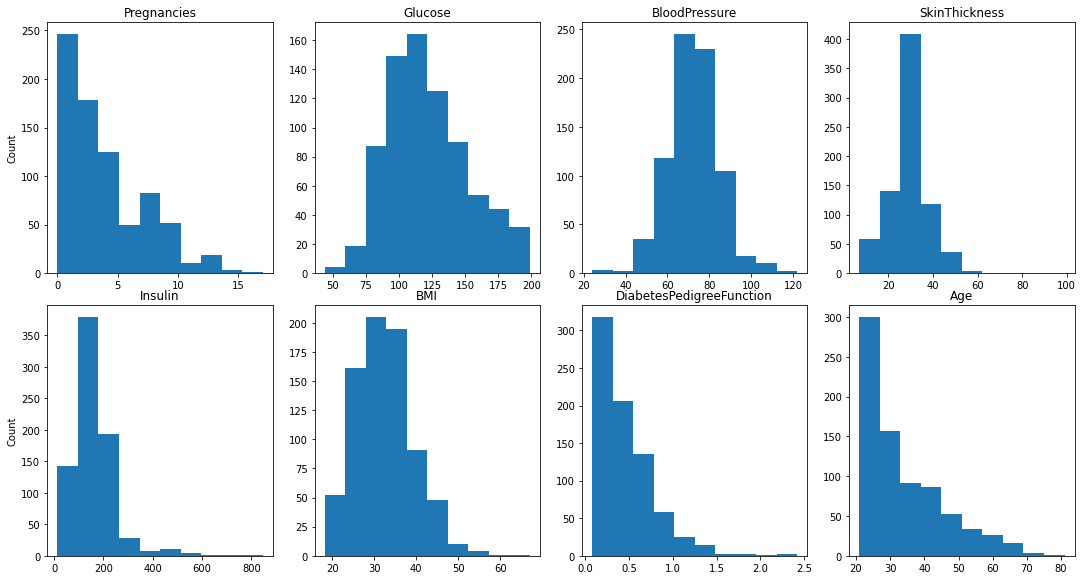

In [14]:
X = pd.DataFrame(diabetes_data_new).to_numpy()[:, 0:8]

fig, ax = plt.subplots(2,4,figsize=(15,8))
fig.tight_layout()

col = 0
for i in range(2):
    ax[i, 0].set_ylabel('Count')
    for j in range(4):
        ax[i, j].hist(X[:, col])  
        ax[i, j].set_title(column_names[col])   
        col += 1
plt.show()

## 2.3 Outlier Handling

Text(0, 0.5, 'Values (centimeters)')

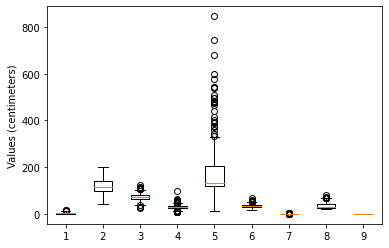

In [15]:
# make boxplots to identify outliers
# standard deviation

plt.boxplot(diabetes_data_new)
plt.ylabel('Values (centimeters)')
#plt.xticks([1, 2, 3, 4],['sepal length','sepal width','petal length','petal width’])


In [16]:
# TODO: do it for 75 and 25 or 95 and 5
# count outliers

Q1 = diabetes_data_new.quantile(0.10)
Q3 = diabetes_data_new.quantile(0.90)
IQR = Q3 - Q1

((diabetes_data_new < (Q1 - 1.5 * IQR)) | (diabetes_data_new > (Q3 + 1.5 * IQR))).sum()

Pregnancies                  0
Glucose                      0
BloodPressure                0
SkinThickness                1
Insulin                     18
BMI                          0
DiabetesPedigreeFunction     4
Age                          0
Outcome                      0
dtype: int64

# 2.4 Scaling, because of algorithms

There are big differences in values, so we scale such that the algorithms are not biased, such as KNN

In [17]:
# scaling the dataset
X = pd.DataFrame(diabetes_data_new).to_numpy()[:, 0:8]
y = pd.DataFrame(diabetes_data_new).to_numpy()[:, 8]

X_scaled = RobustScaler().fit_transform(X, y)
X = pd.DataFrame(X_scaled).to_numpy()[:, 0:8]

# 2.5 Cleaned data

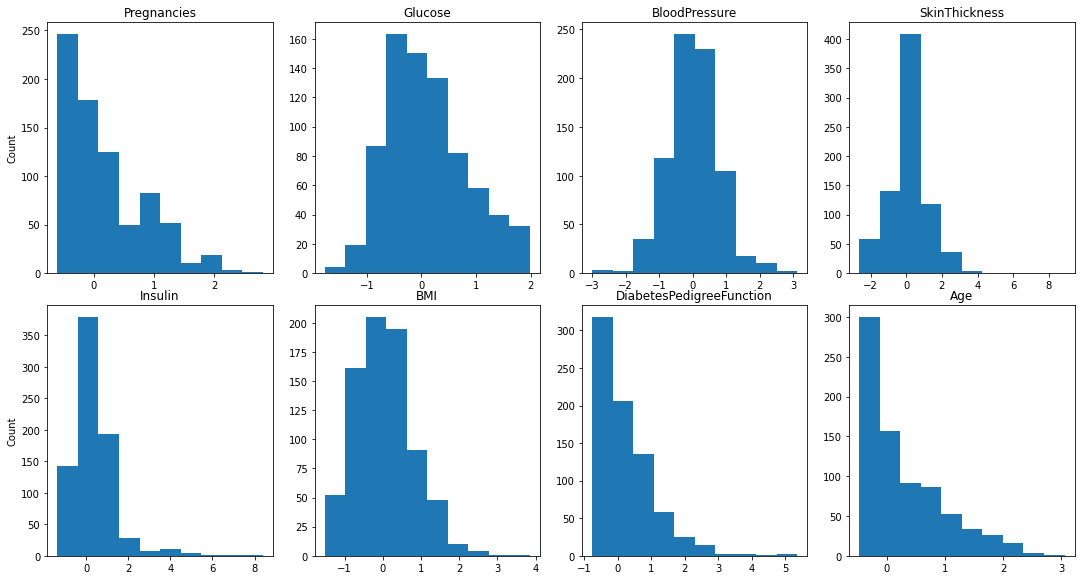

In [18]:
fig, ax = plt.subplots(2,4,figsize=(15,8))
fig.tight_layout()

col = 0
for i in range(2):
    ax[i, 0].set_ylabel('Count')
    for j in range(4):
        ax[i, j].hist(X[:, col])  
        ax[i, j].set_title(column_names[col])   
        col += 1
plt.show()

# Algorithms

In [19]:
random_state = 1234
splits = 10
algo_names = ["DTC", "KNN", "SVM"]
algorithms = []
algorithms.append(tree.DecisionTreeClassifier(random_state=random_state))
algorithms.append(KNeighborsClassifier())
algorithms.append(svm.SVC(random_state=random_state))

parameters = []
parameters.append({
        'criterion':  ['gini', 'entropy'],
        'max_depth':  [None, 2, 4, 6, 8, 10, 12, 14, 16],
        'splitter': ['best', 'random'],
        'min_samples_split': [2, 10, 15, 20, 25, 50, 100]})

parameters.append({
    'n_neighbors': list(range(1, 31)),
    'metric': ['euclidean', 'cosine', 'manhattan']})

parameters.append({
    'C': [0.1, 1, 10, 100], 
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']})


# do nested cross validatoin for hyperparamater optimization
y_trues = []
y_preds = []
accuracy = []
for i, clf in enumerate(algorithms):

    cv_outer = StratifiedKFold(n_splits=splits, shuffle = True, random_state=random_state)
    
    y_trues.append([])
    y_preds.append([])
    accuracy.append([])
    
    for train, test in cv_outer.split(X, y):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        cv_inner = StratifiedKFold(n_splits=3, shuffle = True, random_state=random_state)
        
        model = algorithms[i]
        params = parameters[i]
        
        gs = GridSearchCV(model,
                          param_grid=params,
                          scoring='accuracy',
                          cv=cv_inner,
                          refit = True)
        
        result = gs.fit(X_train, y_train)
        best_model = gs.best_estimator_

        y_pred = best_model.predict(X_test)

        y_trues[i].append(y_test)
        y_preds[i].append(y_pred)

        acc = accuracy_score(y_test, y_pred)

        accuracy[i].append(acc)

        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (mean(accuracy[i]), std(accuracy[i])))

>acc=0.857, est=0.871, cfg={'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 10, 'splitter': 'best'}
>acc=0.883, est=0.874, cfg={'criterion': 'gini', 'max_depth': None, 'min_samples_split': 20, 'splitter': 'best'}
>acc=0.857, est=0.874, cfg={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 25, 'splitter': 'best'}
>acc=0.857, est=0.847, cfg={'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 25, 'splitter': 'best'}
>acc=0.805, est=0.870, cfg={'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 20, 'splitter': 'random'}
>acc=0.922, est=0.857, cfg={'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 20, 'splitter': 'best'}
>acc=0.870, est=0.857, cfg={'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 10, 'splitter': 'best'}
>acc=0.844, est=0.852, cfg={'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 15, 'splitter': 'best'}
>acc=0.882, est=0.853, cfg={'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2, 's

# Analysis

In [20]:
# make nice table with basic stats of the accuracy score, so .describe() function to compare the clfs,for each classifier
# plot accuracies 
acc = np.empty((splits, len(algorithms)), dtype=float)
for i, classifier in enumerate(algorithms):
    for j in range(splits):
        acc[j][i] = accuracy_score(y_trues[i][j], y_preds[i][j])
results = pd.DataFrame(acc, columns = algo_names)

In [21]:
results.describe()

,DTC,KNN,SVM
count,10.000000,10.000000,10.000000
mean,0.861979,0.858014,0.835919
std,0.030762,0.016203,0.021616
min,0.805195,0.828947,0.802632
25%,0.847403,0.847403,0.821429
50%,0.857143,0.857143,0.837662
75%,0.878717,0.870130,0.856673
max,0.922078,0.883117,0.857143


In [22]:
display(results)

,DTC,KNN,SVM
0,0.857143,0.883117,0.857143
1,0.883117,0.857143,0.857143
2,0.857143,0.870130,0.831169
3,0.857143,0.857143,0.831169
4,0.805195,0.870130,0.857143
5,0.922078,0.870130,0.844156
6,0.870130,0.857143,0.805195
7,0.844156,0.844156,0.818182
8,0.881579,0.842105,0.855263
9,0.842105,0.828947,0.802632


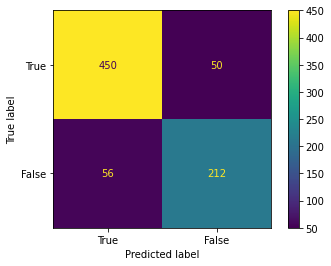

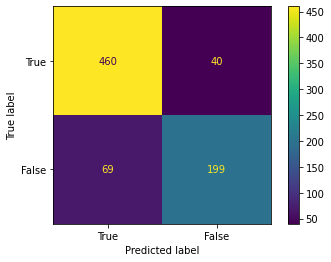

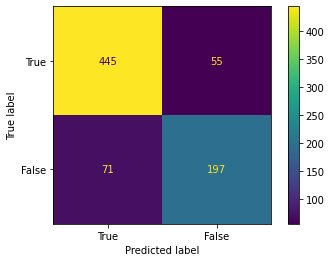

In [23]:
# plot confusion matrices TODO: use confusion_matrix and just plot it nicely

for i, classifier in enumerate(algorithms):
    y_true_flat = list(np.concatenate(y_trues[i]).flat)
    y_pred_flat = list(np.concatenate(y_preds[i]).flat)

    ConfusionMatrixDisplay.from_predictions(y_true_flat, y_pred_flat, display_labels=['True','False'])

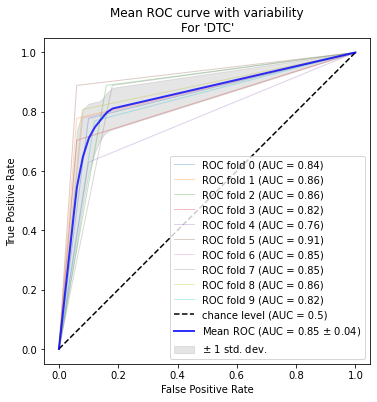

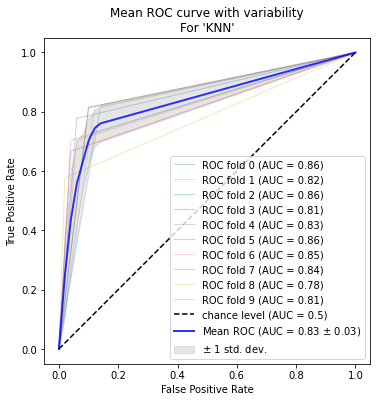

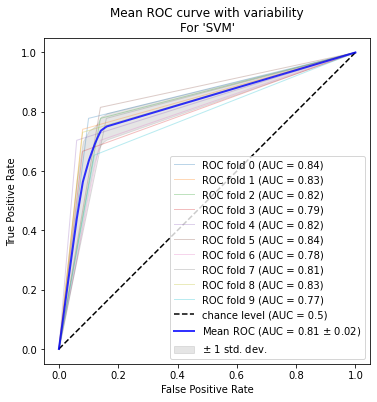

In [24]:
#plot roc curves
for i, classifier in enumerate(algorithms):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))

    for fold in range(splits):
        viz = RocCurveDisplay.from_predictions(
            y_trues[i][fold],
            y_preds[i][fold],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\nFor '{algo_names[i]}'",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

In [25]:
# sign test

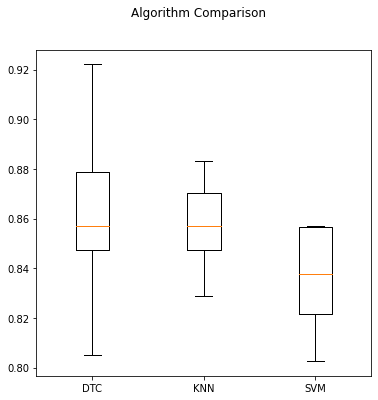

In [26]:
#plot boxplots

# boxplot algorithm comparison
fig = plt.figure(figsize=(6,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc)
ax.set_xticklabels(algo_names)
plt.show()